### Encoding / Decoding ECG signals for deep learning

1. Investigate reconstruction (loss) from scalograms
2. Investigate reconstruction using GGM
3. Investigate reconstruction using spectrograms 

In [1]:
%pip install ssqueezepy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torchaudio 
import wfdb
import sys
import wfdb
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import stft
from wfdb import processing
from skimage import transform

print('Virtual Environment:')
print(sys.prefix)


Virtual Environment:
c:\Users\Pie\Desktop\Thesis\code\signal-denoising\.venv


In [2]:
def plot_multiple_timeseries(signals, names):
    num_signals = len(signals)
    
    plt.figure(figsize=(5 * num_signals, 4))

    for i, (signal, name) in enumerate(zip(signals, names), 1):
        plt.subplot(1, num_signals, i)
        plt.plot(signal)
        plt.title(name)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

#### Scalograms

In comparison to Matlab, pwts does not come with an icwt method. Therefore, the original pwts implementation is moved to src folder. Because of this issue, we used an alternative library https://github.com/OverLordGoldDragon/ssqueezepy?tab=readme-ov-file. The starter code is taken from: https://dsp.stackexchange.com/questions/87097/why-is-inverse-cwt-inexact-inaccurate. Read more about cwt, dwt and stft here: https://dsp.stackexchange.com/questions/76624/continuous-wavelet-transform-vs-discrete-wavelet-transform. 

In [4]:
# Load record
samples = 512 ; Fs=360
record = wfdb.rdsamp('data/ardb/108', sampto=samples)   # extract first ... samples
I = record[0][:, 0]                                     # extract first lead
print(I.shape)

(512,)


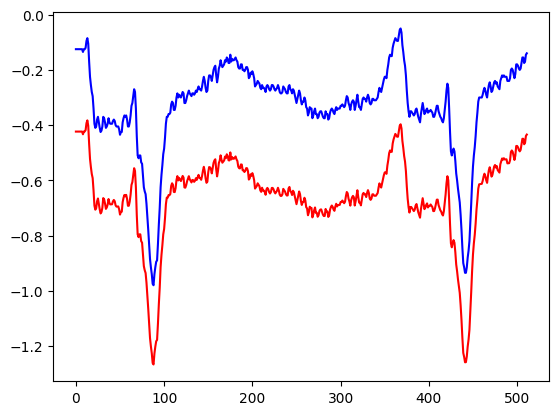

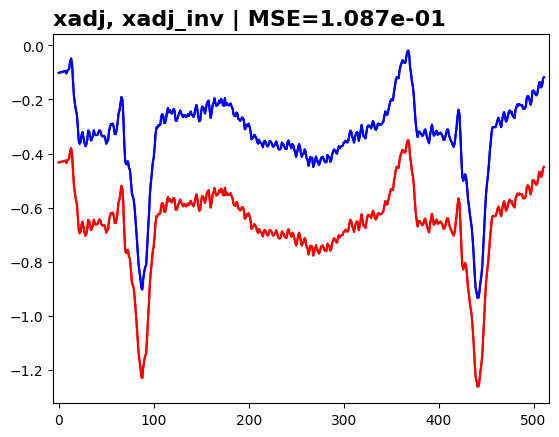

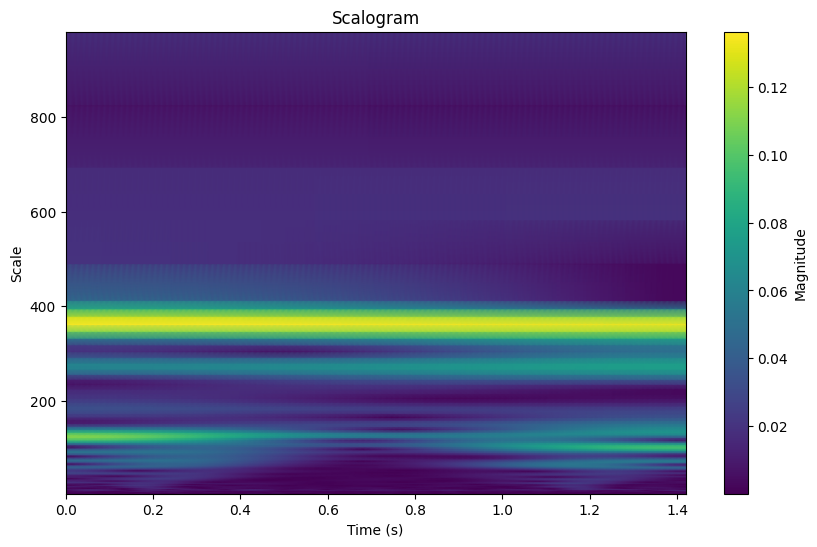

Shape original scalogram (114, 512)
(512, 512)


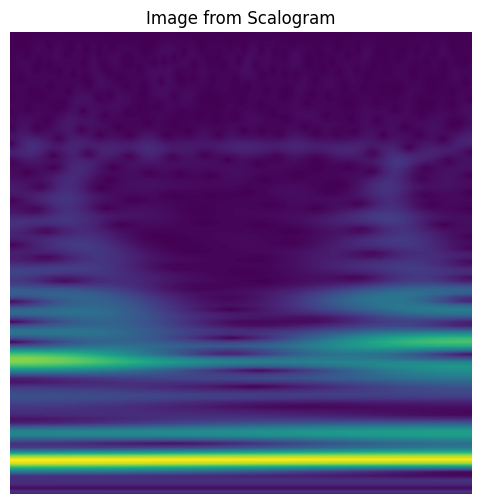

(512,)


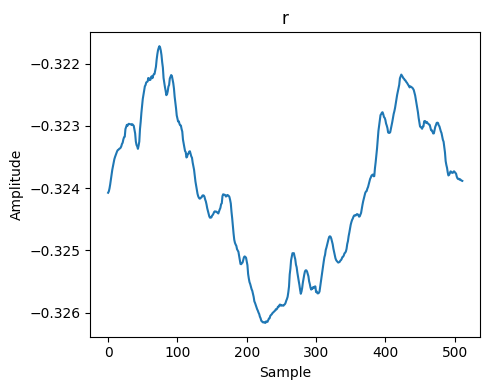

In [5]:
import numpy as np
from numpy.fft import rfft, irfft
import matplotlib.pyplot as plt
from ssqueezepy import cwt, icwt, Wavelet, padsignal
from ssqueezepy.visuals import plot, plotscat
from skimage.transform import resize

# ************************************
# ************************************
# Code adapted from: 
# https://dsp.stackexchange.com/questions/87097/why-is-inverse-cwt-inexact-inaccurate.

wavelet = Wavelet('morlet')
nv = 16

t=samples; x=I; x_mean = x.mean()

plt.plot(x,color='b')

Wx, scales = cwt(x, wavelet=wavelet, nv=nv)
x_inv = icwt(Wx, wavelet=wavelet, nv=nv, x_mean=x_mean)

plt.plot(x_inv,color='r')
plt.show()

#%%
xf = rfft(x)
xf[1:3] = 0
xadj = irfft(xf)
x_mean = xadj.mean()

Wx, scales = cwt(xadj, wavelet=wavelet, nv=nv, padtype=None)
x_inv = icwt(Wx, wavelet=wavelet, scales=scales, nv=nv, x_mean=x_mean)

plot(xadj, color='b')
plot(x_inv, color='r', title="xadj, xadj_inv | MSE=%.3e" % np.mean((xadj-x_inv)**2))
plt.plot(xadj, color='b')
plt.plot(x_inv, color='r')
plt.show()

# ************************************
# ************************************

# Embed/De-embed Methods
def ecg_to_scalogram(x):
    # Compute CWT
    Wx, scales = cwt(x, wavelet=wavelet, nv=nv)

    return np.abs(Wx), scales  # Return the scalogram and scales

# def scalogram_to_ecg(Wx, scales, x_mean):
#     # Reconstruct signal from scalogram
#     x_inv = icwt(Wx, wavelet=wavelet, scales=scales, nv=nv, x_mean=x_mean)
#     return x_inv


# def scalogram_to_ecg(Wx, scales, x_mean):
#     # Convert scales to the correct data type
#     scales = scales.astype(np.float32)  # or np.float64

#     # Reconstruct signal from scalogram
#     x_inv = icwt(Wx, wavelet=wavelet, scales=scales, nv=nv, x_mean=x_mean)
#     return x_inv

def scalogram_to_ecg(Wx, x_len, x_mean):
    # Generate scales based on the length of Wx
    scales = np.arange(1, x_len + 1)
    scales = scales.astype(np.float32)  # or np.float64

    # Reconstruct signal from scalogram
    x_inv = icwt(Wx, wavelet=wavelet, scales=scales, nv=nv, x_mean=x_mean)
    return x_inv

# Visualizations
def plot_scalogram(x, Fs):
    # Compute CWT
    Wx, scales = cwt(x, wavelet=wavelet, nv=nv)

    # Get time array
    t = np.arange(len(x)) / Fs

    # Plot scalogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, scales, np.abs(Wx), shading='gouraud')
    plt.ylabel('Scale')
    plt.xlabel('Time (s)')
    plt.title('Scalogram')
    plt.colorbar(label='Magnitude')

    # Show plot
    plt.show()

def plot_multiple_scalograms(signals, Fs_list, names):
    num_signals = len(signals)
    num_rows = 1
    num_cols = num_signals
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_signals, 4))

    for i, (signal, Fs, name) in enumerate(zip(signals, Fs_list, names)):
        ax = axs[i] if num_signals > 1 else axs
        
        # Compute CWT
        Wx, scales = cwt(signal, wavelet=wavelet, nv=nv)

        # Get time array
        t = np.arange(len(signal)) / Fs

        # Plot scalogram
        im = ax.pcolormesh(t, scales, np.abs(Wx), shading='gouraud')
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time (s)')
        ax.set_title(name)
        fig.colorbar(im, ax=ax, label='Magnitude')

    plt.tight_layout()
    plt.show()

# Additional Methods
def normalize_image(img):
    # Normalize image to range [0, 1]
    img_min = np.min(img)
    img_max = np.max(img)
    normalized_img = (img - img_min) / (img_max - img_min)
    return normalized_img

def scalogram_to_image(scalogram, target_shape):
    # Normalize scalogram
    print('Shape original scalogram', scalogram.shape)

    normalized_scalogram = normalize_image(scalogram)
    
    # Resize scalogram to target shape
    resized_scalogram = resize(normalized_scalogram, target_shape, mode='reflect')
    
    # Convert to 8-bit image (optional)
    scaled_image = (resized_scalogram * 255).astype(np.uint8)
    
    return scaled_image

def visualize_image(image):
    # Plot the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)  # Assuming the image is grayscale
    plt.axis('off')  # Turn off axis
    plt.title('Image from Scalogram')
    plt.show()

def image_to_scalogram(image, target_shape):
    # Resize image to original scalogram shape
    resized_image = resize(image, target_shape, mode='reflect')

    # Denormalize the image
    denormalized_image = resized_image / 255.0

    # Convert the image back to a scalogram
    scalogram = denormalized_image

    return scalogram

def image_to_ecg(image, x_shape, x_mean):
    # Convert image to scalogram
    scalogram = image_to_scalogram(image, x_shape)

    # Reconstruct ECG signal from scalogram
    x_len = x_shape[0]  # Assuming x_shape is a tuple (num_samples, num_features)
    reconstructed_ecg = scalogram_to_ecg(scalogram, x_len, x_mean)

    return reconstructed_ecg

# Assuming you have the signal x and its sampling frequency Fs defined earlier
plot_scalogram(x, Fs)

# Convert to image.. for U-Net
scalogram, scales = ecg_to_scalogram(x)

target_shape = (512, 512)  # Adjust as needed

# Convert scalogram to image
image = scalogram_to_image(scalogram, (512, 512))

print(image.shape)
visualize_image(image)


# Image to ECG
reconstructed_ecg= image_to_ecg(image,I.shape, x_mean)

print(reconstructed_ecg.shape)

plot_multiple_timeseries([reconstructed_ecg], 'reconstructed_ecg')

#### Encoding Timeseries for Deep Learning
We can use an alternative approach from this paper (https://arxiv.org/pdf/1506.00327.pdf) also used in a paper that used diffusion models to generate ECG signals (https://arxiv.org/pdf/2303.02475.pdf).

Further researched in this paper (https://www.researchgate.net/figure/Conceptual-block-diagram-of-the-proposed-structure-for-individual-household-power_fig4_338359485)

Not investigated: 
- recurrence plots

In [14]:
# From paper 'Generating ECG using Diffusion Models' (2023)
from pyts.image import MarkovTransitionField

def rescale_time_series(X):     
    """
    Rescale the time series X to fall within the interval [-1, 1].
    
    Parameters:
    X (array-like): The input time series.
    
    Returns:
    X_rescaled (array-like): The rescaled time series.
    """
    # Min-Max scaling: 
    # https://github.com/devitrylouis/imaging_time_series/blob/master/gramian_angular_field.py
    min_ = np.amin(X)
    max_ = np.amax(X)
    scaled_serie = (2*X - max_ - min_)/(max_ - min_)
    # Floating point inaccuracy!
    scaled_serie = np.where(scaled_serie >= 1., 1., scaled_serie)
    scaled_serie = np.where(scaled_serie <= -1., -1., scaled_serie)

    return scaled_serie


mtf = MarkovTransitionField()

# Embedd 
def ecg_to_ggm(X):
    # Rescale
    X = rescale_time_series(X)

    # Calculate the radius values 'r' using the time stamps
    r = np.arange(1, len(X) + 1) / len(X)

    # Calculate the angular values 'phi' using the rescaled time series
    phi = np.arccos(X)

    # Compute GASF matrix
    N = len(X)
    GASF = np.zeros((N, N))
    N = len(X)
    GADF = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            GASF[i, j] = np.cos((phi[i] + phi[j]) / 2)
            GADF[i, j] = np.cos((phi[i] - phi[j]) / 2)

    transformer = MarkovTransitionField()
    # Compute MTF matrix
    MTF = transformer.transform(X.reshape(1,-1))
    MTF = MTF[0]  

    return np.stack((GASF, GADF, MTF),axis=-1)

# Reconstruct
def ggm_to_ecg(ggm):
    # Extract GASF channel
    gasf_channel = ggm[:, :, 0]
    
    # Extract diagonal elements
    diagonals = np.diagonal(gasf_channel)

    return diagonals

In [15]:
# Visualizations
def plot_ggm(embeddings, names, title='ECG 2D'):
    num_embeddings = len(embeddings)

    plt.figure(figsize=(5 * num_embeddings, 5))

    for i, (embedding, name) in enumerate(zip(embeddings, names), 1):
        plt.subplot(1, num_embeddings, i)
        plt.imshow(embedding)
        plt.title(name)
        plt.xlabel('Time')
        plt.ylabel('Time')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


We must verify our reconstruction.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GGM Shape (512, 512, 3)


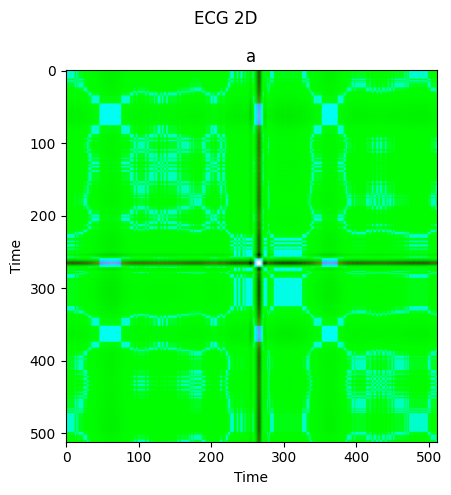

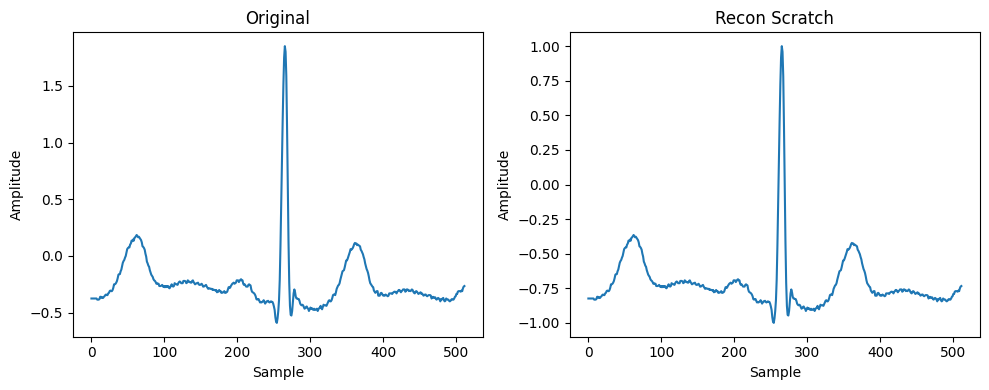

Mean Squared Error Loss: 0.2264047228383878


In [17]:
from sklearn.metrics import mean_squared_error

# Load data
samples = 128 * 4
Fs = 360
record = wfdb.rdsamp('data/ardb/103', sampto=samples)  # extract first ... samples
I = record[0][:, 0]  # extract first lead

ggm = ecg_to_ggm(I)

print('GGM Shape', ggm.shape)

ts_recon = ggm_to_ecg(ggm)

plot_ggm([ggm],['a'])
plot_multiple_timeseries([I, ts_recon], ['Original', 'Recon Scratch'])

# Compute loss between original and reconstruction
mse_loss = mean_squared_error(I, ts_recon)
print("Mean Squared Error Loss:", mse_loss)

#### Updated Spectrogram Methods

Since we know there is not a lot of import infromation above 180 hZ , we decide to use the (magnitude) of spectogram up to 180 Hz. This is partly inspired by this parer: https://www.google.com/search?client=firefox-b-d&q=Atrial_Fibrillation_Detection_Using_Deep_Features_.pdf. We could 'pre' downsample the signal (I suppose).. but we keep working with signals at 360 Hz.

Now... a real problem! We lose phase information, which means we will have to work with a lossy reconstruction. Some paper did not clearly mention this by saying... used pytorchaudio and done. There are multiple ways to adress this issue. Some great recources can be found here:

- https://pytorch.org/audio/stable/transforms.html
- https://reference.wolfram.com/language/ref/InverseSpectrogram.html
- https://de.mathworks.com/help/signal/ug/signal-recovery-with-differentiable-scalograms-and-spectrograms.html#SignalRecoveryWithDifferentiableSPExample-1 

Approach 1:

- Using lossy conversion with Griffin [PytorchAudio]

In [9]:
def ecg_to_spectrogram(ecg_signal, n_fft=400, hop_length=None):
    """
    Convert ECG signal to spectrogram using torchaudio library.

    Args:
    - ecg_signal (torch.Tensor): 1D tensor representing the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Spectrogram of the ECG signal.
    """
    # Reshape ECG signal to (batch_size, num_channels, signal_length)
    ecg_signal = ecg_signal.unsqueeze(0).unsqueeze(0)

    # Compute spectrogram
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)(ecg_signal)

    return spectrogram

def spectrogram_to_ecg(spectrogram, n_fft=400, hop_length=None):
    """
    Convert spectrogram back to ECG signal using torchaudio library.

    Args:
    - spectrogram (torch.Tensor): Spectrogram of the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Reconstructed ECG signal.
    """
    # Compute inverse spectrogram
    ecg_signal = torchaudio.transforms.GriffinLim(n_fft=n_fft, hop_length=hop_length)(spectrogram)

    # Squeeze the batch and channel dimensions
    ecg_signal = ecg_signal.squeeze(0).squeeze(0)

    return ecg_signal



sig = torch.tensor(signal_102)
spek = ecg_to_spectrogram(sig)
# visualize_spectrogram(spek)
reconstructed_sig = spectrogram_to_ecg(spek)


#  TODO:
#  - add a method.. visualize spectrogram

NameError: name 'signal_102' is not defined

Great looking spectrogram from scratch...

In [ ]:
import torch
from torchaudio import transforms
from torchaudio.functional import inverse_spectrogram


def ecg_to_spectrogram(ecg_signal):

    I_tensor = torch.tensor(ecg_signal)
    # Compute the STFT
    stft = torch.stft(I_tensor, n_fft=128, center=True, pad_mode='reflect', normalized=True, onesided=True, return_complex=True)
    magnitude = torch.abs(stft)

    log_magnitude = 10 * torch.log10(magnitude)
 
    return log_magnitude


# Define spectrogram_to_ecg function
def spectrogram_to_signal(spectrogram):
    magnitude = 10 ** ((spectrogram / 20))  # Convert back to magnitude
    phase = np.random.rand(*magnitude.shape) * 2 * np.pi  # Random phase
    stft_complex = magnitude * np.exp(1j * phase)  # Combine magnitude and phase
    signal = torch.istft(torch.tensor(stft_complex), n_fft=128, center=True, normalized=True, onesided=True, return_complex=False)
    return signal.numpy()

def visualize_spectrogram(spectrogram):
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='jet')
    plt.xlabel('Time')
    plt.ylabel('Frequency Bin')
    plt.title('Spectrogram')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()


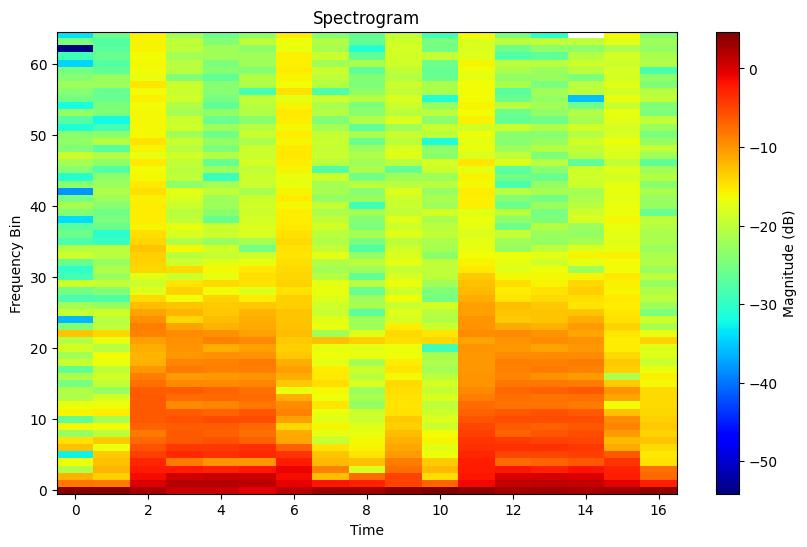

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram  # Import the Hanning window function
import wfdb

record_104 = wfdb.rdsamp("data/ardb/102",sampto=540)
signal_104 = record_104[0][:, 0]

spek = ecg_to_spectrogram(signal_104)

visualize_spectrogram(spek)


# visualize_spectrogram(spek[:2])

#  = spectrogram_to_signal(spek)

# plot_multiple_timeseries([signal_104, sig], ['Original', 'Reconstructed'])


